# Säutsud pythonis

## Sissejuhatus

Käesoleva kirjatüki eesmärk on mudeldada pythonis säutsude teemasid. Selleks tehakse järgnevat:
 - laetakse twitterist säutsud alla
 - säutsud puhastatakse
 - ehitatakse teemadem udelid kasutades _Latent Dirichlet allocation_ algoritmi
 - tulemused visualiseeritakse

Esmalt defineerime hunniku funktsioone, mis teevad elu lihtsamaks.

In [1]:
def teksti_eraldaja(tweedid):
    """eraldab säutsude listist teksti. 
    sisend: säutsude metaandmete list, mis on tulnud funktsioonist allalaadija
    väljund: säutsude tekstide list"""
    tekst=[]
    for i in range(len(tweedid)):
        tekst.append(tweedid[i]['text'])  
    return tekst   

import math as math
def allalaadija(märksõna, kogus, keel='en'):
    """laeb twitterist säutsud alla
    sisend: -märksõna: otsisõna, mille kohta otsime twitterist säutsusid
    -kogus: mitu säutsu tahame. Kogus on 100 säutsu täpsusega (nt kogus=101, korjab 200 säutsu, kogus=99 korja 100 säutsu
    -keel: mis keelseid säutsusid tahame)
    väljund: - list tweetide andmetega"""
    loopideArv=math.ceil(kogus/100)
    print("Tsükkel nr:", str(1)+ ", veel tsükleid:",str(loopideArv-1))
    tweedid=twitter.search(q=märksõna,lang=keel, count=100)
    tulem=tweedid['statuses']
    minid=min_id(tweedid)
    for i in range(loopideArv-1):
        print("Tsükkel nr:", str(i+2)+ ", veel tsükleid:",str(loopideArv-i-2))
        uuedtweedid=twitter.search(q=märksõna,lang=keel, count=100, 
                                   max_id=minid)
        tulem+=uuedtweedid['statuses']
        minid=min_id(uuedtweedid)
    return tulem

def min_id(tweedid):
    """abifunktsioon funktsioonile allalaadija, mis leiab allalaaditud tweetide id miinimumi, selle saab
    anda sisendiks järgmisele loobile, et võtta tweedid, mille id on väiksem kui siin leitud id
    sisend: - tweetide sõnastik
    väljund: - tweetide sõnastiku id miinimum"""
    ids=[]
    for i in range(len(tweedid['statuses'])):
        ids.append(tweedid['statuses'][i]['id'])
    return min(ids)

from nltk.tokenize import RegexpTokenizer
import re
def tokeniseerija(tekstlist):
    """funktsioon, mis võtab sisendiks teksti listi ning teeb neist tokenid (iga sõna eraldi listi elemendiks) ning 
    eemaldab numbrid, kirjavahemärgid, lingid ja twitteri kasutajanimed ning teeb teksti väiketähtedeks
    sisend: - tekstilist (iga lause on 1 string)
    väljund: - tokenite list"""
    tokenizer = RegexpTokenizer(r'\w+')
    tokens=[]
    for i in range(len(tekstlist)):
        #eemaldame kasutajanimed ja lingid, numbrid ja kirjavahemärgid
        abimuutuja=re.sub(r'(^https?:\/\/.*[\r\n]*)|(@[A-Za-z0-9]+)|([0-9])|(\w+:\/\/\S+)', '', tekstlist[i].lower(), 
                          flags=re.MULTILINE)
        tokens.append(tokenizer.tokenize(abimuutuja))
    return tokens

from stop_words import get_stop_words
def puhastaja(tokenslist, myralist):
    """funktsioon, mis puhastab tokenite listi stoppsõnadest ja kasutaja poolt määratud sõnadest ning sõnadest, mille
    pikkus on alla 3
    sisend: - tokenslist: tokenite list
    - myralist: list sõnadest, mida tahetakse veel eemaldada
    väljund: - tokenite list, kus eelnev on eemaldatud"""
    stopsonad = get_stop_words('en')#inglise keel stoppsõnad
    stopsonad.extend(myralist)#paneme veel juurde
    #eemaldame stoppsõnad ja sõnad alla 2 täheärgi
    tokens_stopped=[]
    for j in range(len(tokenslist)):
        tokens_stopped.append([i for i in tokenslist[j] if not i in stopsonad and len(i)>2])   
    return tokens_stopped

from nltk.stem.porter import PorterStemmer
def stemming(tokens):
    """funktsioon, mis normaliseerib sõnad lõigates maha käände- ja pöördelõpud.
    sisend: - tokens: tokenite list
    väljudn: - normaliseeritud sõnade list"""
    p_stemmer = PorterStemmer()
    stemmed=[]
    for j in range(len(tokens)):
        stemmed.append([p_stemmer.stem(i) for i in tokens[j]]) 
    return stemmed

def sonede_dict(sonedelist):
    """funktsioon, mis paneb ühe listi tokensid kokku üheks stringiks
    sisend: -tokensite listid
    väljund: -tokensite listid, kus iga list on üks tokensite string"""
    token_dict={}
    for i in range(len(sonedelist)):
        token_dict[i] = ' '.join(sonedelist[i])
    return token_dict

from __future__ import print_function
def print_top_sonad(model, feature_names, n_top_words):
    """funktsioon, mis prindin top sõnad iga teema kohta
    sisend: - model: lda mudel
    -feature_names: doc-term maatriksist sõnade nimed
    n_top_words: kui mitu top sõna iga teema kohta kuvatakse
    väljund: -prindib teema ja selle top sõnad"""
    for topic_idx, topic in enumerate(model.components_):
        print("Teema #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
import matplotlib.pyplot as plt
import numpy as np
def teema_doku_plot(doc_topic,teemade_arv, doc_n, teemad):
    """funktsioon, mis joonistab plotid, kus x-teljel on teema ja y-teljel teema kaal. Joonistab tõenäosuse jagunemise iga tweeti kohta
    sisend: - doc_topic: dokumendi teema array
    - teemade_arv: mitu teemat mudelis on
    - doc_n: dokumentide indeksid listi kujuna, mille kohta tahame ploti joonistada
    -teemad: teemade list
    Väljund: -plot"""
    %matplotlib inline
    f, ax= plt.subplots(len(doc_n), 1, figsize=(8, 6), sharex=True)
    for i, k in enumerate(doc_n):
        #normaliseerin iga rea, kuna muidu läheb üle 1
        ax[i].stem(doc_topic[k,:]/(sum(doc_topic[k,:])),
                 linefmt='r-', markerfmt='ro', basefmt='w-')
        ax[i].set_xlim(-0.1, teemade_arv-0.9)
        ax[i].set_ylim(0, 1)
        ax[i].set_xticks(np.arange(0, teemade_arv, 1)) 
        ax[i].set_xticklabels(teemad)
        ax[i].set_axis_bgcolor((1,0.98,0.98))
        ax[i].set_ylabel("Prob")
        ax[i].set_title("Säuts {}".format(k))
    ax[len(doc_n)-1].set_xlabel("Teema")
    plt.tight_layout()
    plt.show()

## Andmete korjamine 

Andmete korjamiseks kasutan eelloodud funktsioone ja paketti twython.

In [2]:
from twython import Twython
#ühendus twitteriga, keyde ja salasõnade jaoks rega enda app: https://dev.twitter.com/ 
#ja loe twythoni kohta http://twython.readthedocs.io/en/latest/#
twitter = Twython('sinu_api_vaartus','sinu_api_vaartus','sinu_api_vaartus', 'sinu_api_vaartus')

In [6]:
estonia=allalaadija('estonia', 2000)
latvia=allalaadija('latvia', 2000)
#salvestame, et igal korral ei peaks uue päringu tegema
import json
json.dump(estonia, open("estonia.txt",'w'))
json.dump(latvia, open("latvia.txt",'w'))

In [7]:
#laeme salvestatud failid üles
estonia = json.load(open("estonia.txt"))
latvia=json.load(open("latvia.txt"))

## Andmete töötlus ja puhastamine 

In [8]:
#eraldame teksti
estoniatkst=teksti_eraldaja(estonia)
latviatkst=teksti_eraldaja(latvia)

In [9]:
#tokeniseerime
esttoken=tokeniseerija(estoniatkst)
lattoken=tokeniseerija(latviatkst)

In [10]:
#puhastame
estpuhas=puhastaja(esttoken,['estonia'])
latpuhas=puhastaja(lattoken,['latvia'])

In [11]:
#stemming
eststem=stemming(estpuhas)
latstem=stemming(latpuhas)

## Mudeli ehitamine

Mudeli ehitamiseks katsetame erinevaid python pakette. Esmalt pakett gensim.

In [12]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import warnings
warnings.filterwarnings('ignore')#et igasugu hoiatusi siin ei kuvaks

C:\Users\Risto\Anaconda3\lib\site-packages\gensim\utils.py:840: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Risto\Anaconda3\lib\site-packages\gensim\utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


Määrame teemade arvu. Selle jaoks kasutasin interaktiivseid visualiseeringuid (vt allapoole), kuni leidsin maksimaalse arvu teemasid, kui teemad ei kattunud. See pole küll teab mis super meetod (temade arvu määramine ongi keeruline), kuid on üheks võimaluseks. Käesoleval juhul on mõlemat andmeseti puhul teemade arvuks määratud kolm.

In [13]:
n_topics_est=3
n_topics_lat=3

In [14]:
estdictionary = Dictionary(eststem)
estcorpus = [estdictionary.doc2bow(text) for text in eststem]
#mudel
estmudel = LdaModel(corpus=estcorpus, id2word=estdictionary, 
                    iterations=500, num_topics=n_topics_est, random_state=1)

Mudeli eripäraks on, et ta ei anna ette, mis teemad tekstis on. Ta annab vihjed, mis teema olla võib näidates ära sõnad, mis teemat kõige paremini esindavad.

In [15]:
#teemad sõnadega
estmudel.print_topics(num_topics=3, num_words=3)

[(0, '0.019*"amp" + 0.014*"poland" + 0.014*"nato"'),
 (1, '0.014*"baltic" + 0.013*"lithuania" + 0.012*"watch"'),
 (2, '0.018*"tallinn" + 0.013*"world" + 0.013*"via"')]

Tundub, et esimene tema on seotud NATO, teine Baltikumi ning kolmas Tallinnaga. Visualiseerime tulemused.

In [16]:
#interaktiivne visualiseerimine
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel
estldavis=pyLDAvis.gensim.prepare(estmudel, estcorpus, estdictionary)

C:\Users\Risto\Anaconda3\lib\site-packages\funcy\decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
C:\Users\Risto\Anaconda3\lib\site-packages\funcy\decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
C:\Users\Risto\Anaconda3\lib\site-packages\funcy\decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
C:\Users\Risto\Anaconda3\lib\site-packages\funcy\decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
C:\Users\Risto\Anaconda3\lib\site-packages\funcy\decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
C:\Users\Risto\Anaconda3\lib\site-packages\funcy\decora

In [17]:
pyLDAvis.display(estldavis)

In [18]:
#sama asi Läti tweetide puhul
latdictionary = Dictionary(latstem)
latcorpus = [latdictionary.doc2bow(text) for text in latstem]
#mudel
latmudel = LdaModel(corpus=latcorpus, id2word=latdictionary, 
                    iterations=500, num_topics=n_topics_lat, random_state=1)
latmudel.print_topics(num_topics=3, num_words=3)

[(0, '0.024*"riga" + 0.021*"europ" + 0.018*"holiday"'),
 (1, '0.011*"bowl" + 0.011*"nine" + 0.010*"just"'),
 (2, '0.018*"riga" + 0.016*"don" + 0.014*"amp"')]

Esimene teema tundub olevat seotud pühadega, teine spordiga, kolmas on rahvusvaheline teema.

In [19]:
latldavis=pyLDAvis.gensim.prepare(latmudel, latcorpus, latdictionary) 
pyLDAvis.display(latldavis)

## Teine variant 

Proovime paketti sklearn teemade mudeldamiseks. Esmalt viime andmed sobivasse formaati.

In [20]:
estdict=sonede_dict(eststem)
latdict=sonede_dict(latstem)

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
#teeb dokumendi-sõna maatriksi
tfest = CountVectorizer(stop_words='english')
tflat = CountVectorizer(stop_words='english')
tfsest = tfest.fit_transform(estdict.values())
tfslat = tflat.fit_transform(latdict.values())

In [22]:
#Mudeli ehitamine
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn
lda_est = LatentDirichletAllocation(n_topics=3, random_state=1)
lda_est.fit_transform(tfsest)
#mudeli paramteerid
lda_est.get_params()
#töötab, sõna doku jagunemine
doc_topic_distrib_est = lda_est.transform(tfsest)

In [23]:
#sama Läti mudeliga
lda_lat = LatentDirichletAllocation(n_topics=3, random_state=1)
lda_lat.fit_transform(tfslat)
#mudeli paramteerid
lda_lat.get_params()

{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_jobs': 1,
 'n_topics': 3,
 'perp_tol': 0.1,
 'random_state': 1,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}

Vaatame teemade top sõnu.

In [24]:
tf_feature_names = tfest.get_feature_names()
print_top_sonad(lda_est, tf_feature_names, 10)
teemad_est=['Balti','Nato','Karusnahk']

Teema #0:
baltic javier world fernandez latvia russia russian hand lithuania countri
Teema #1:
amp tallinn nato poland usa spend greec target member defens
Teema #2:
end help farm good tallinn fur sign plz news christma



Esimene teema tundub olevat seotud lähinaabritega teine NATOga ja kolmas karusnahaga.

In [25]:
print_top_sonad(lda_lat, tf_feature_names, 10)
teemad_lat=['riik','puhkus','vaba aeg']

Teema #0:
unifil dive border normal toner femal smartcountri easili grow saw
Teema #1:
tree reunion recommend andrey telenetucicxwc andrew teddybear snow ezi reunit
Teema #2:
recommend enjoy leav museum hay concentr classi scrap photographi instal



Esimene teema tundub olevat seotud riigiga, teine talvepuhkusega, kolmas vaba aja veetmisega.

In [26]:
ldavis_est=pyLDAvis.sklearn.prepare(lda_est, tfsest, tfest)

In [27]:
pyLDAvis.display(ldavis_est) 

In [ ]:
ldavis_lat=pyLDAvis.sklearn.prepare(lda_lat, tfslat, tflat)

In [31]:
pyLDAvis.display(ldavis_lat) 

In [63]:
#töötab, sõna doku jagunemine
doc_topic_distrib_est = lda_est.transform(tfsest)
doc_topic_distrib_lat = lda_lat.transform(tfslat)

Vaatame säutsude lõikes teemade tõenäosusi.

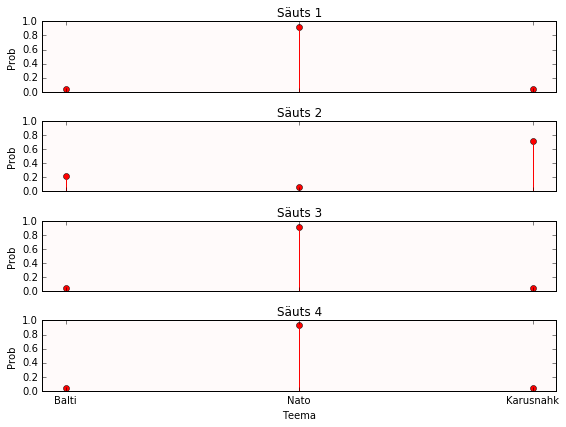

In [88]:
teema_doku_plot(doc_topic_distrib_est, n_topics_est, [1,2,3,4], teemad_est)

In [ ]:
Vaatame esimesest säutsu.

In [46]:
estoniatkst[1]

"RT @JRRCollins: @AviWoolf the NATO aspect is the one that concerns me regarding Turkey. It's not Estonia that scares me, it's agitators lik…"

Eks siin jääb igaühel ise otsustada, kas teema sai õigesti määratud (tund, et enam vähem). Siin tuleb arevstada, et nagu iga mudel, pole ka see täiuslik. Vaatame sama Läti mudeli puhul.

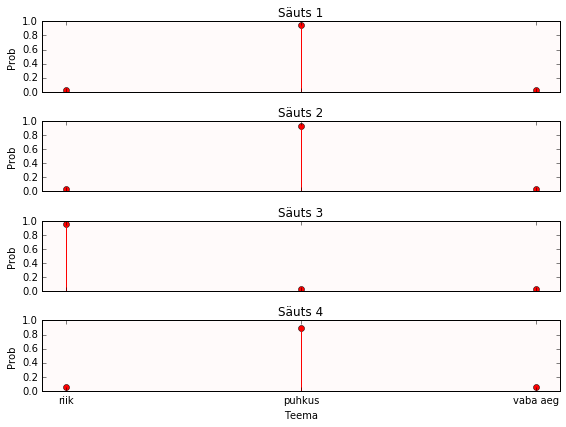

In [89]:
teema_doku_plot(doc_topic_distrib_lat, n_topics_lat, [1,2,3,4], teemad_lat)

In [72]:
latviatkst[1]

'RT @IIHFHockey: France beats Latvia 8-1 and advances to the Final Olympic Qualification where they will play in Japan. Story soon on https:…'